In [1]:
import sys

import polars as pl
import torch
from data_loader.TimeSeriesModule import MultiPartDataModule
from model_runner.model_inference import IMSForecaster, DMSForecaster
from models.Titans import TitanConfigMonthly, LMMModel, TestTimeMemoryManager
from model_runner.model_train import TitanTrain

'''
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
https://developer.nvidia.com/cuda-12-8-0-download-archive
'''

MAC_DIR = '../data/'
WINDOW_DIR = 'C:/Users/USER/PycharmProjects/research/data/'

if sys.platform == 'win32':
    DIR = WINDOW_DIR
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.version.cuda)
    print(torch.__version__)
    print(torch.cuda.get_device_name(0))
    print(torch.__version__)
else:
    DIR = MAC_DIR

True
1
12.8
2.9.0.dev20250716+cu128
NVIDIA GeForce RTX 5080
2.9.0.dev20250716+cu128


In [2]:
model = LMMModel(TitanConfigMonthly())
model.load_state_dict(torch.load(DIR + 'titan_tta_20250912_l12_h_60.pt'))
# model.eval()

<All keys matched successfully>

In [3]:
from utils.date_util import DateUtil

target_dyn_demand = pl.read_parquet(DIR + 'target_dyn_demand.parquet')
data_module = MultiPartDataModule(target_dyn_demand, TitanConfigMonthly(), batch_size = 128, val_ratio = 0.2)
# inference_loader = data_module.get_inference_loader()
# val_loader = data_module.get_val_loader()

plan_yyyymm = 202012
anch_loader = data_module.get_inference_loader_at_plan(
    plan_yyyymm,
    parts_filter=None,
    fill_missing='ffill'
)

ttm = TestTimeMemoryManager(model, lr = 1e-4)
# ims = IMSForecaster(model, lmm_mode = 'eval', ttm = ttm)
dms = DMSForecaster(model, lmm_mode = 'eval', ttm = ttm)
fut_months = DateUtil.next_n_months_from(plan_yyyymm, 120, include_anchor = False)

In [4]:
import torch

@torch.no_grad()
def hybrid_predict_120_at_plan(
    dms,                                   # DMSForecaster 인스턴스 (extend='ims' 지원)
    loader,                                 # get_inference_loader_at_plan(...) 결과
    horizon_total: int = 120,
    context_policy: str = "once",
    device: torch.device | str | None = None,
    reset_memory: bool = False
):
    """
    - 배치 단위로 DMS(첫 블록) + IMS(나머지) 하이브리드 예측을 수행.
    - reset_memory=True면 배치마다 Titan의 contextual memory를 초기화.
    """
    model = dms.model
    device = device or next(model.parameters()).device
    model.eval()

    preds, parts_all = [], []

    for batch in loader:
        if not isinstance(batch, (list, tuple)) or len(batch) != 2:
            raise ValueError("Loader must yield (x_batch, part_ids).")
        x_batch, part_ids = batch  # x: [B,L,1], part_ids: list[str]

        if reset_memory and hasattr(model, "encoder"):
            for layer in model.encoder.layers:
                if hasattr(layer, "attn"):
                    layer.attn.contextual_memory = None

        # y_hat = dms.forecast(
        #     x_init=x_batch, horizon=horizon_total,
        #     extend="ims",                      # DMS 블록 이후 IMS로 자동 확장
        #     context_policy=context_policy,     # 'once' 권장
        #     device=device,
        #     y_true=None, teacher_forcing_ratio=0.0
        # )  # [B, horizon_total]

        y_hat = dms.forecast_overlap_avg(
            x_init = x_batch, horizon = horizon_total,
            context_policy = context_policy,
            clip_mul = 2.0, max_growth = 1.10,
            max_step_up=0.10, max_step_down = 0.30,
            damp_min = 0.2, damp_max = 0.6
        )

        preds.append(y_hat.cpu())
        parts_all.extend(list(part_ids))

    return torch.cat(preds, dim=0), parts_all  # [N, H], list[str]


In [5]:
y_hat_120, parts_batch = hybrid_predict_120_at_plan(
    dms, anch_loader, horizon_total=120, context_policy="once", device=None,
    reset_memory=False   # 배치 간 메모리 독립이 필요하면 True
)

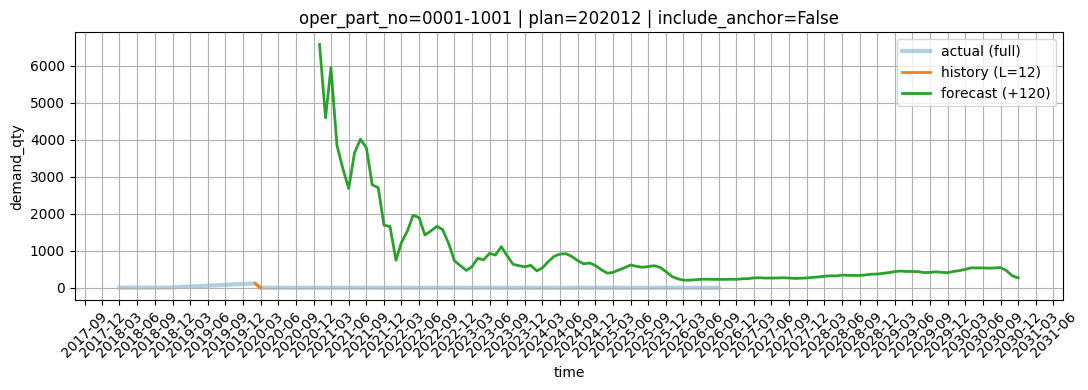

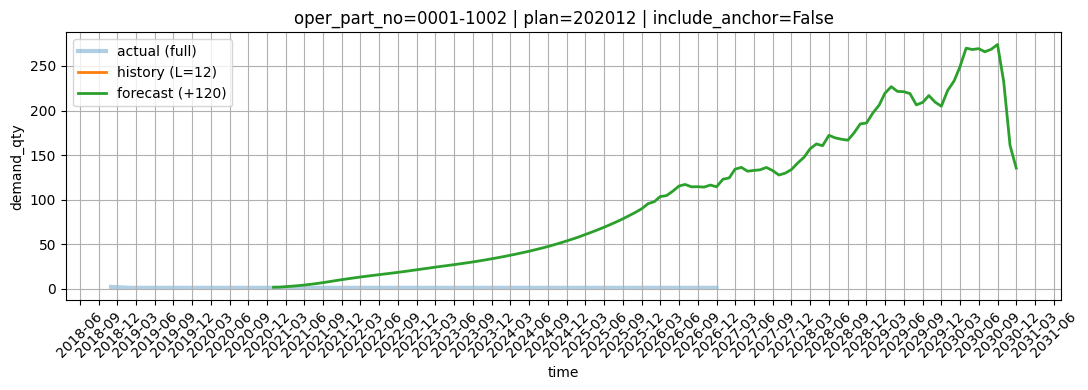

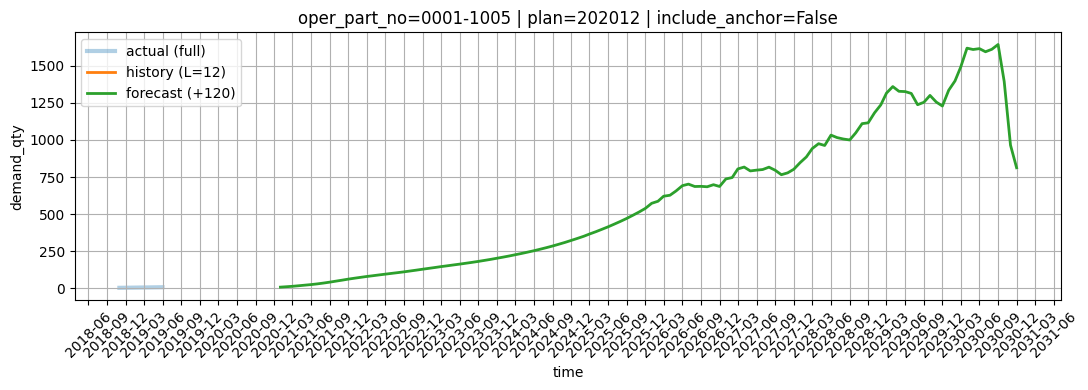

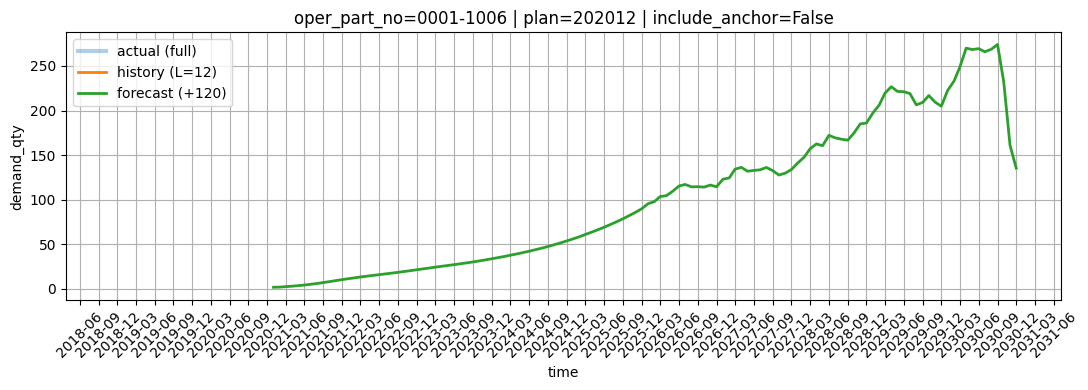

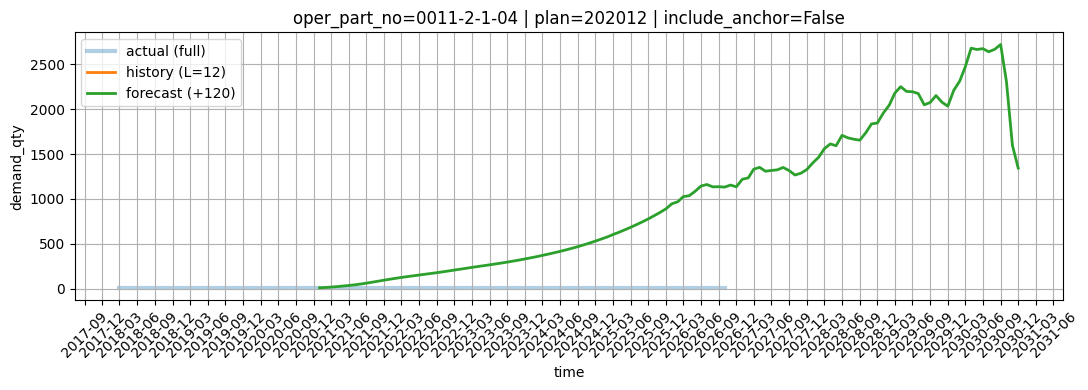

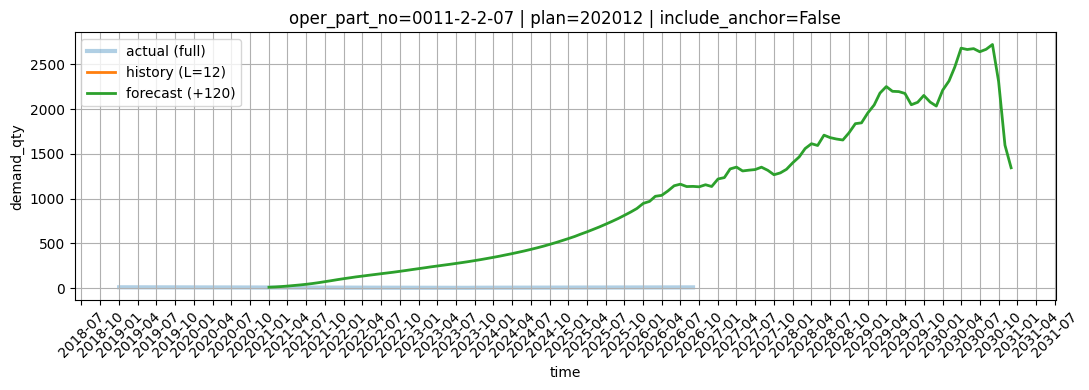

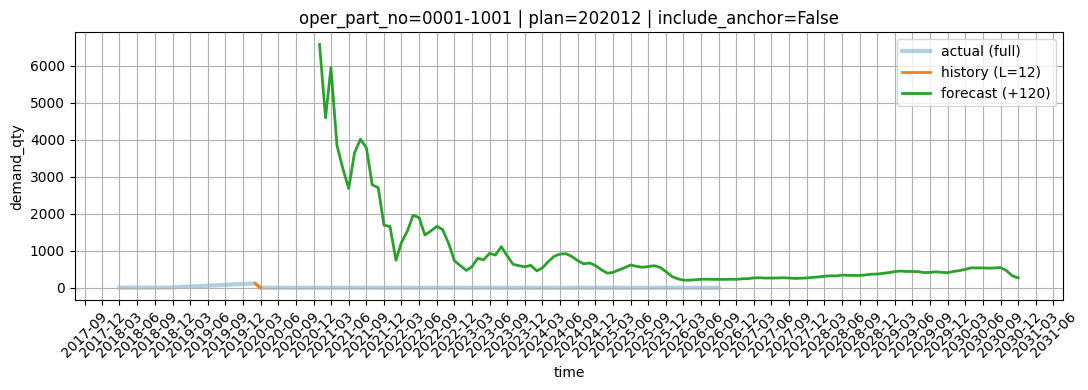

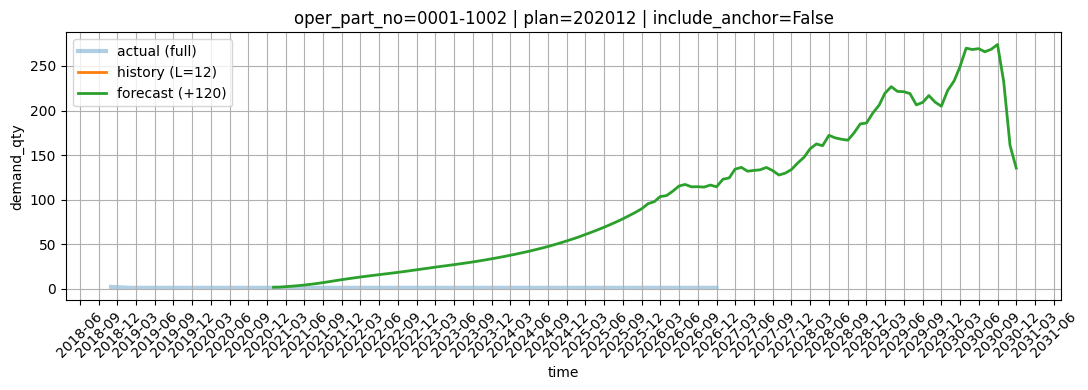

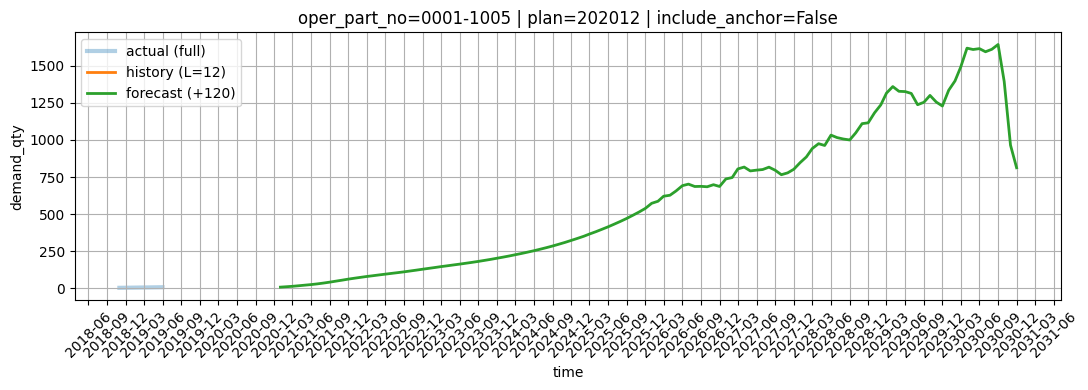

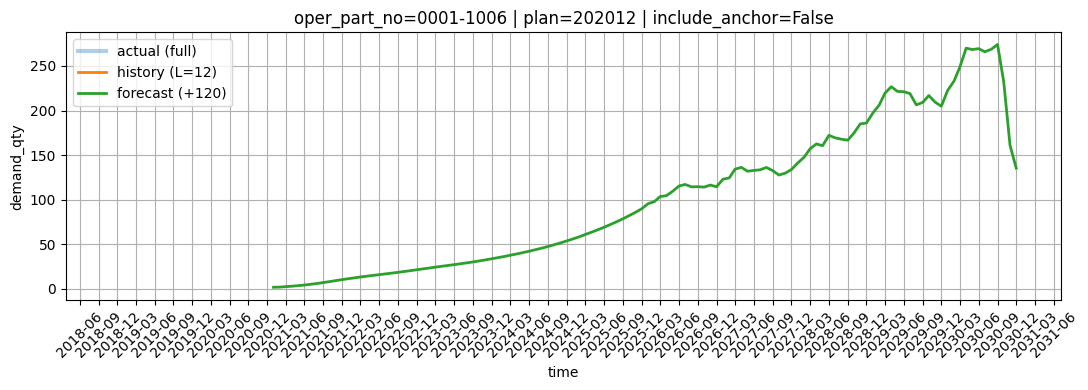

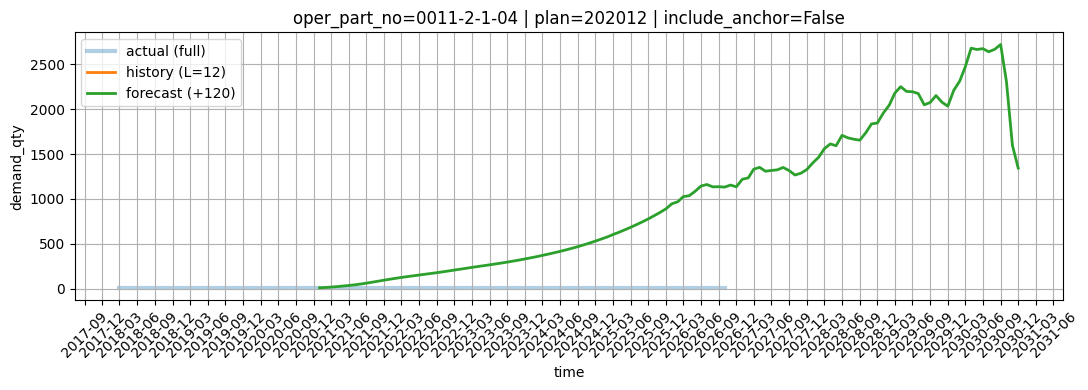

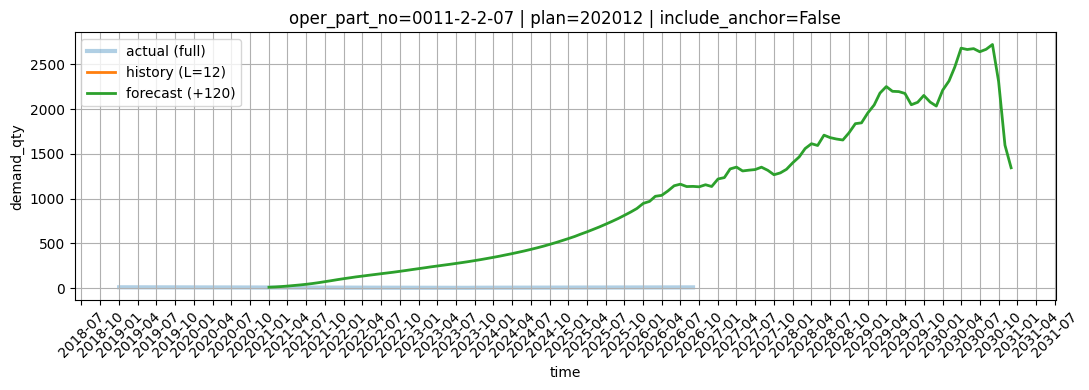

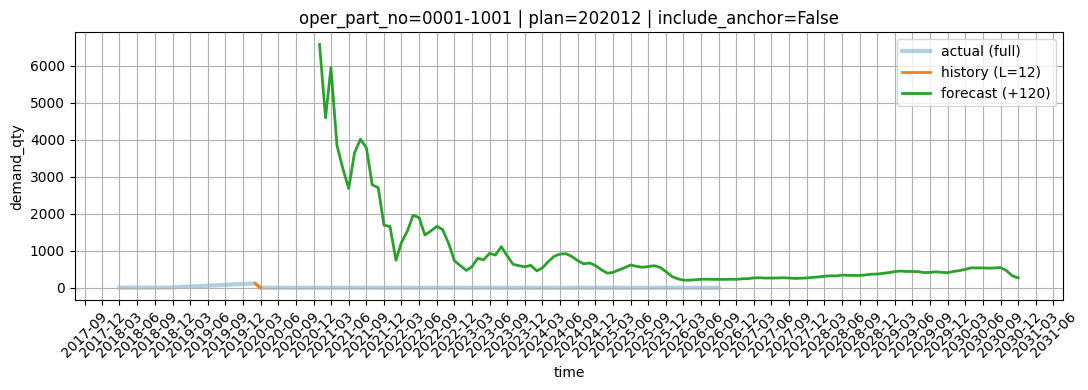

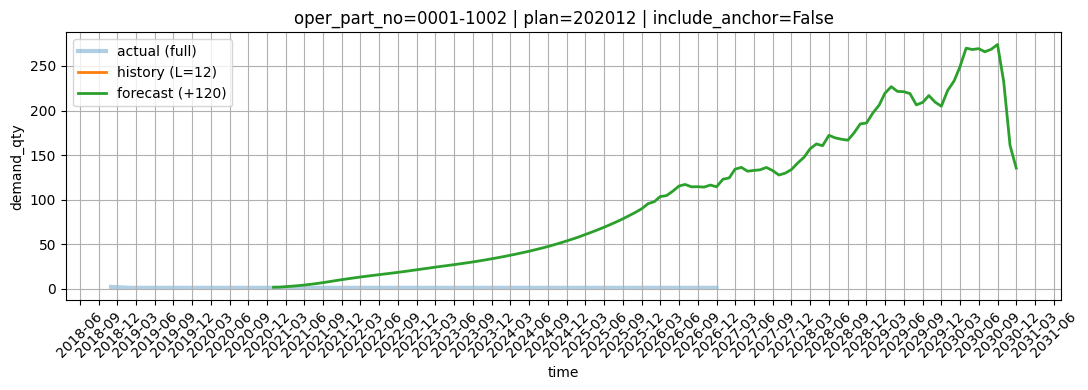

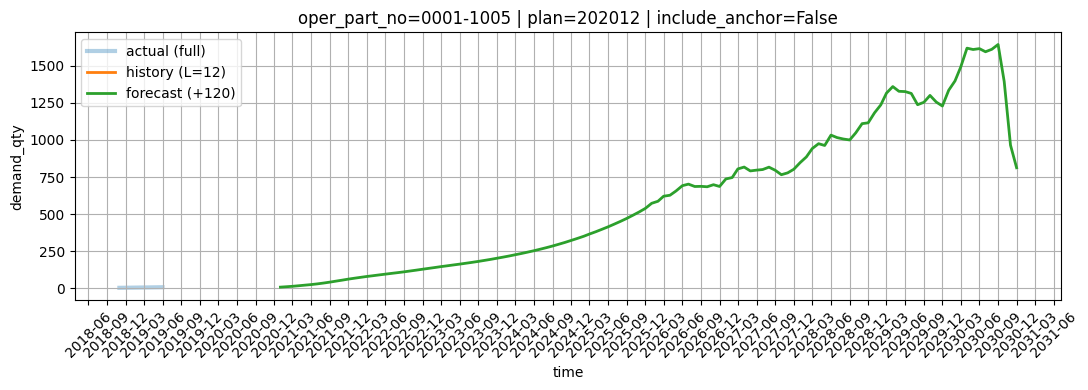

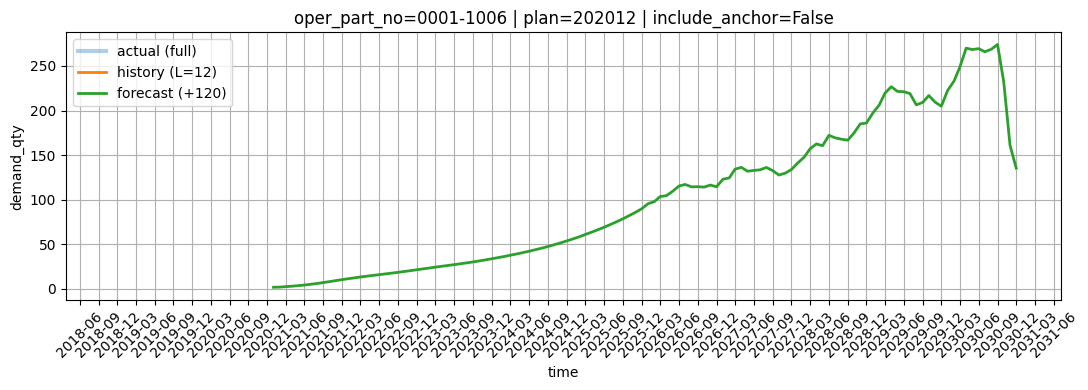

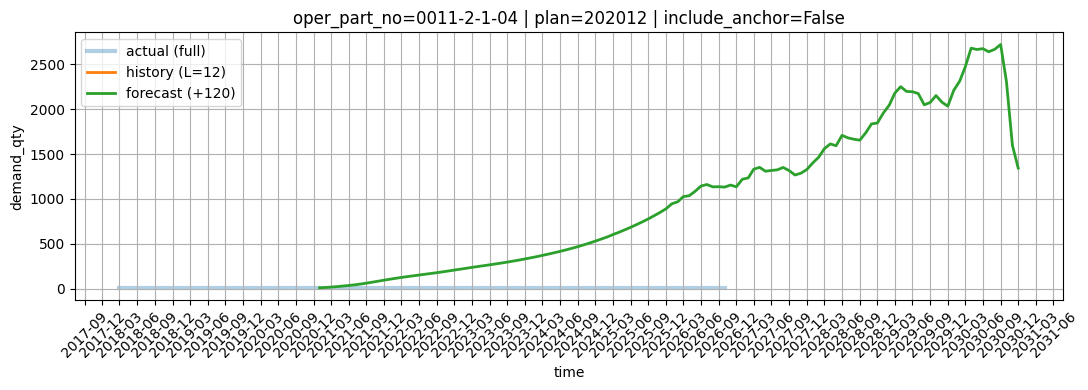

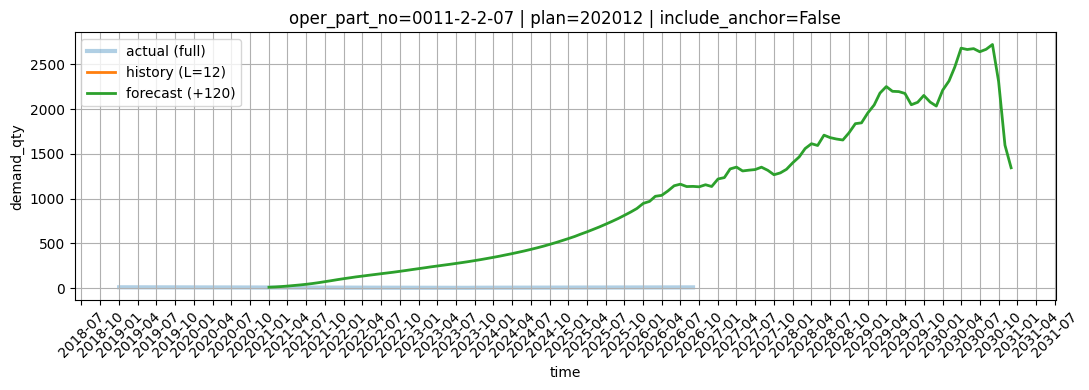

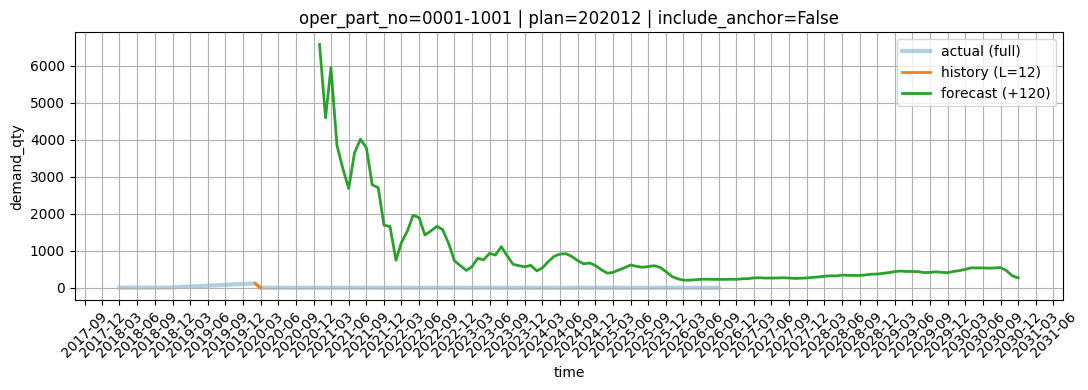

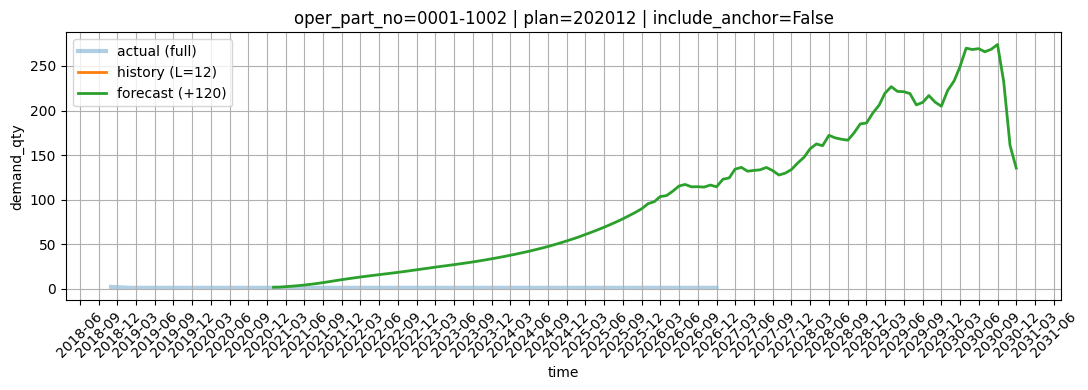

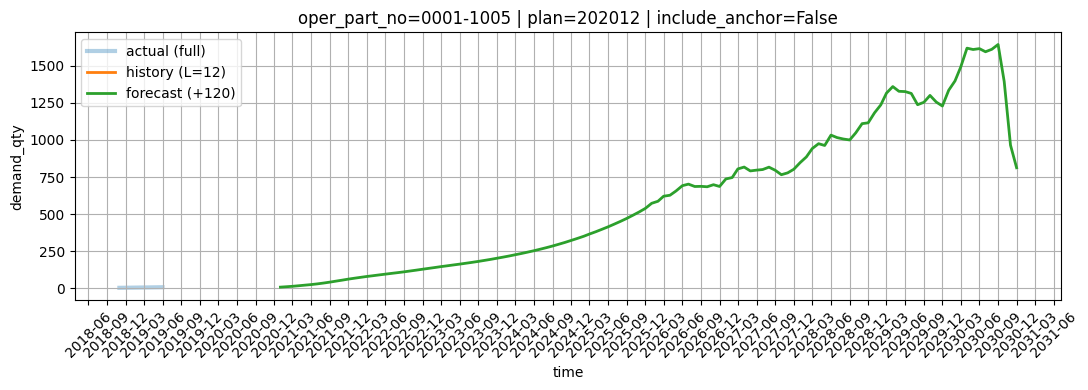

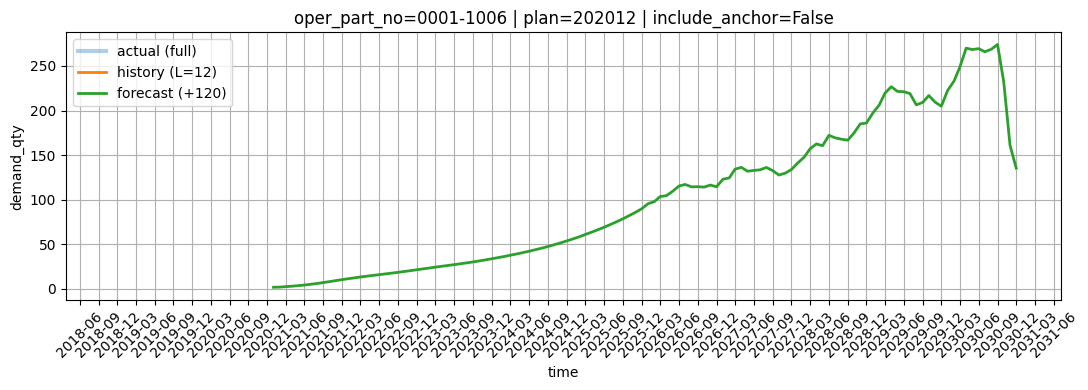

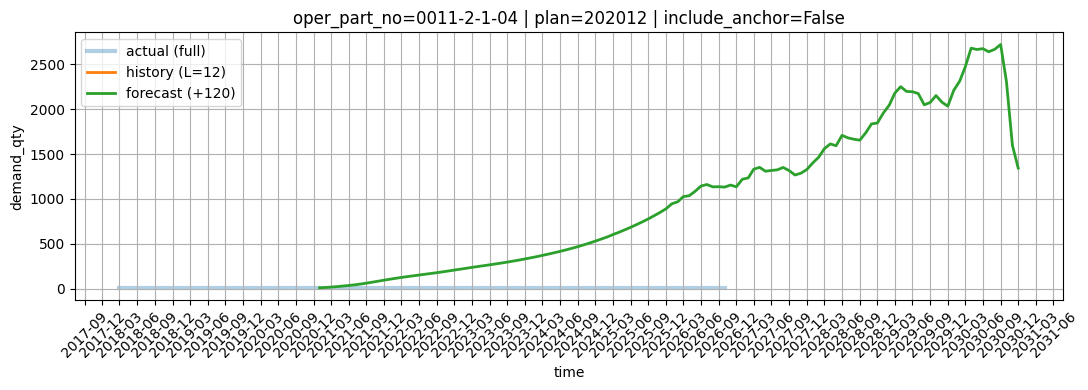

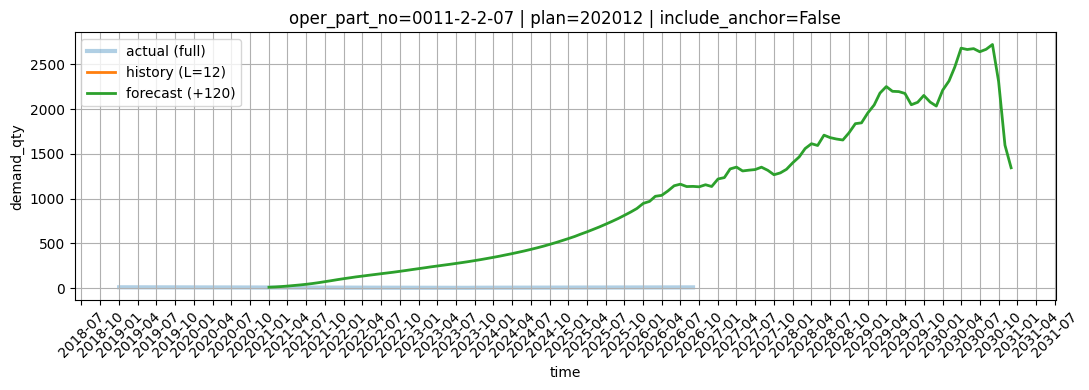

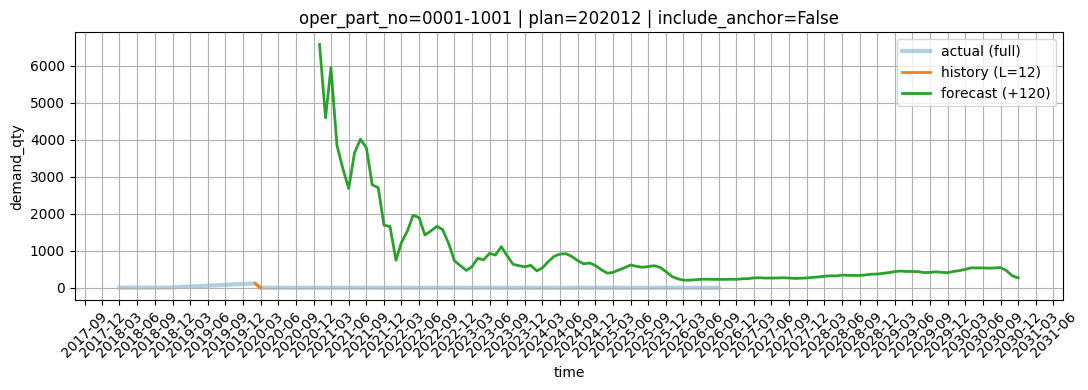

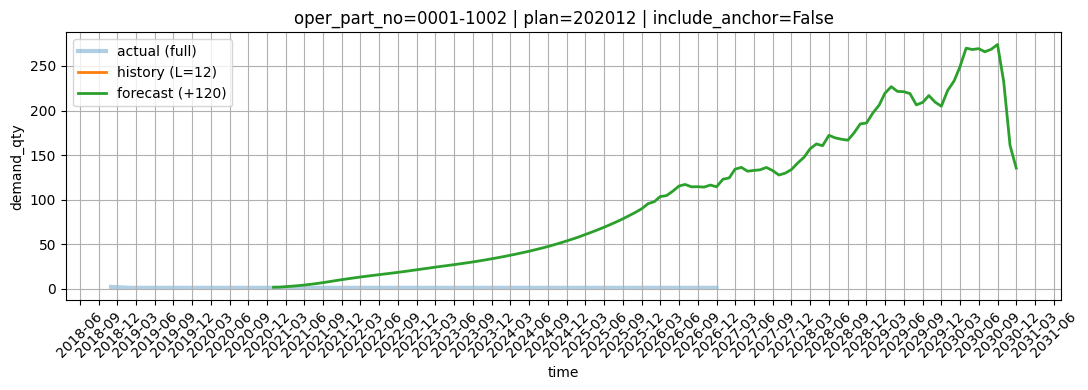

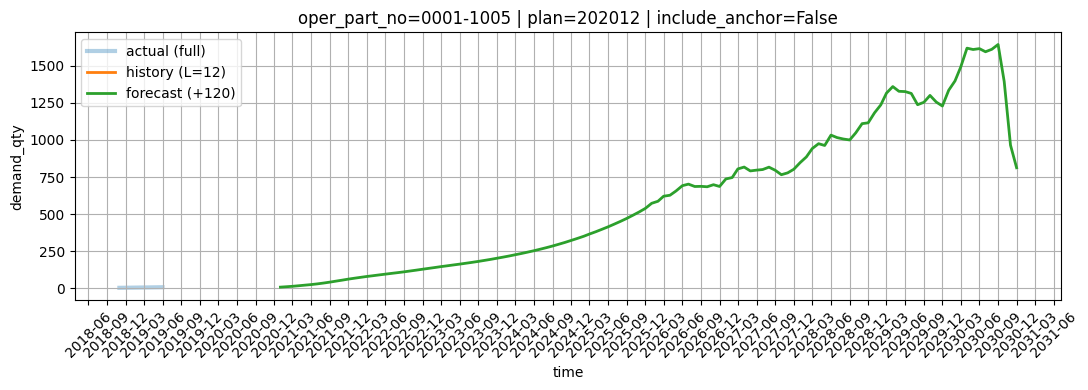

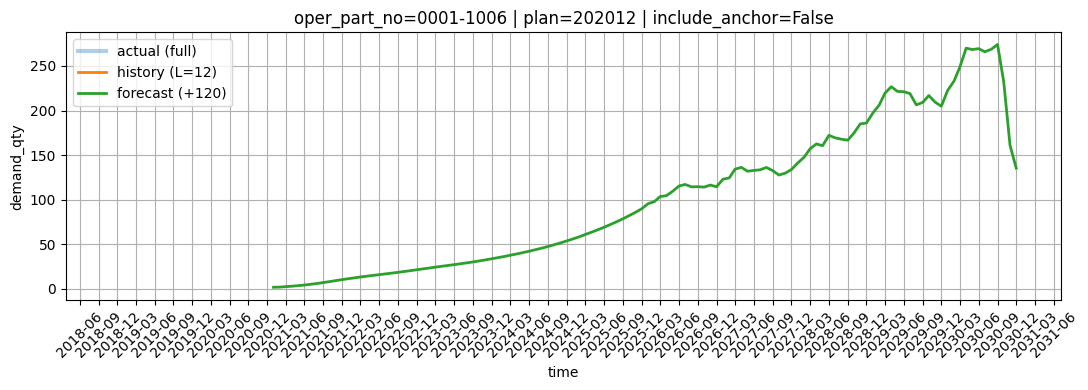

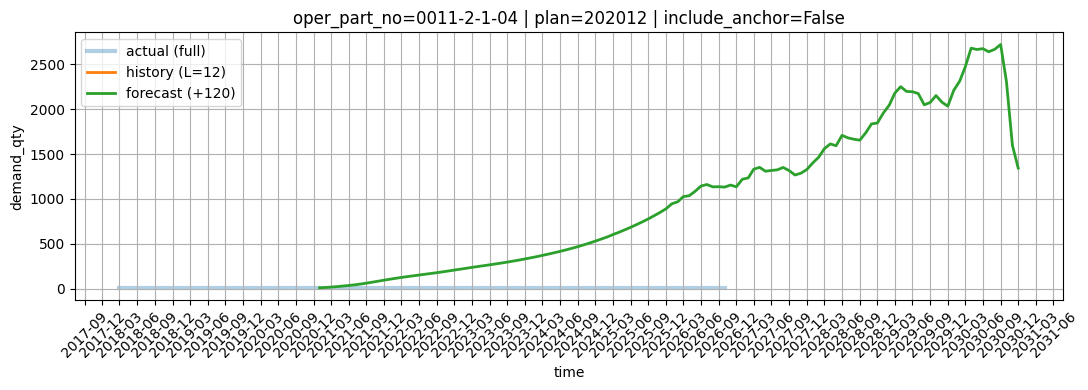

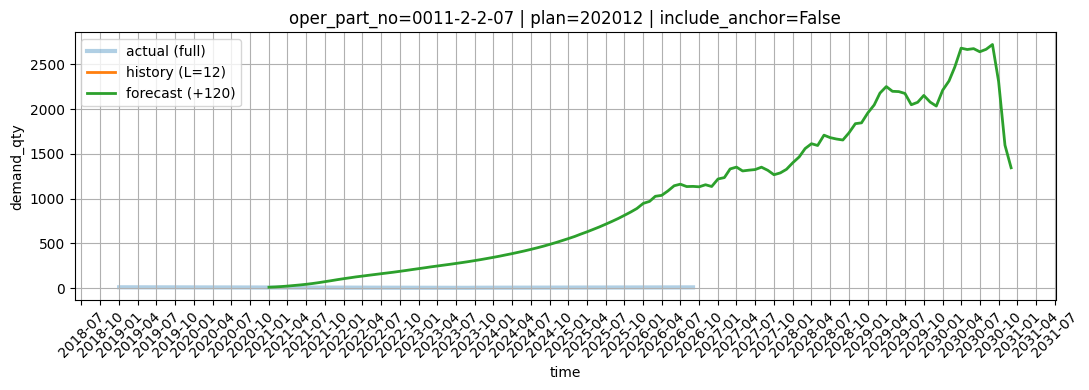

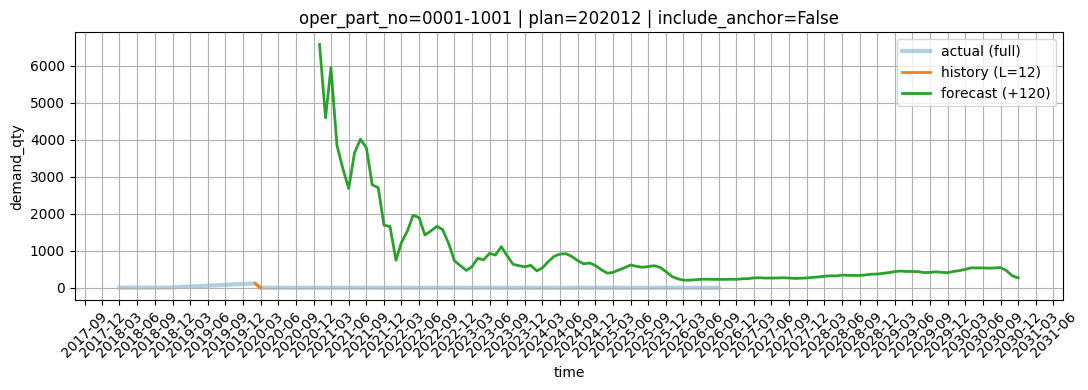

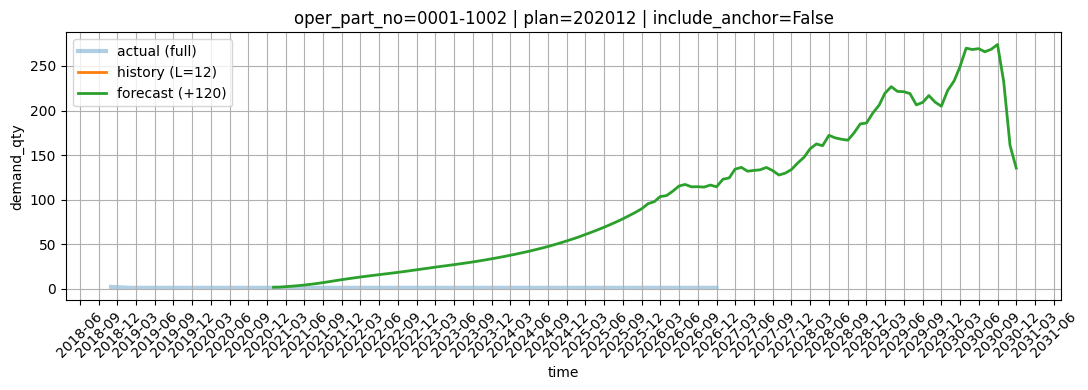

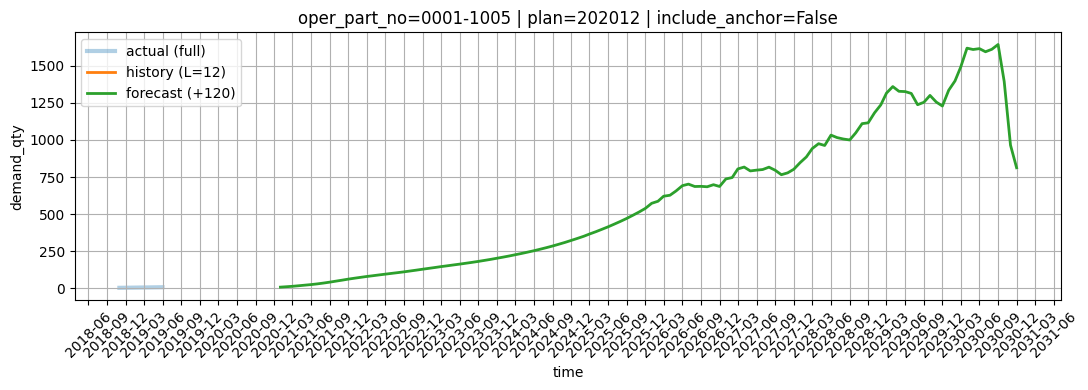

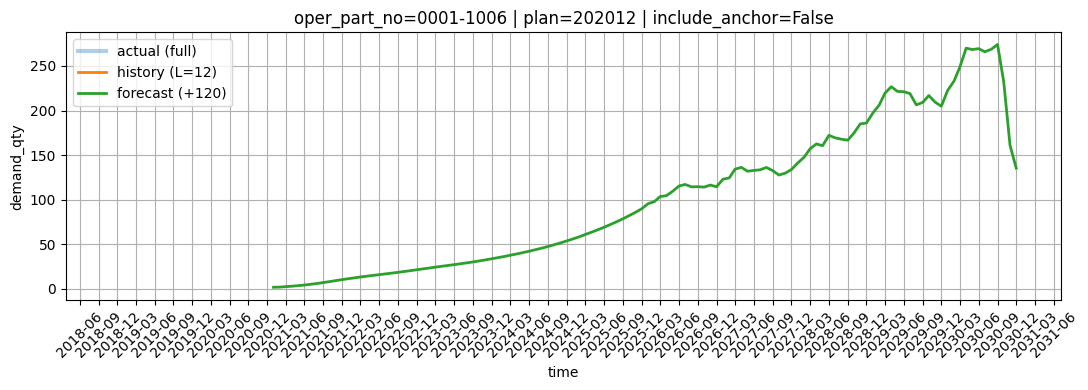

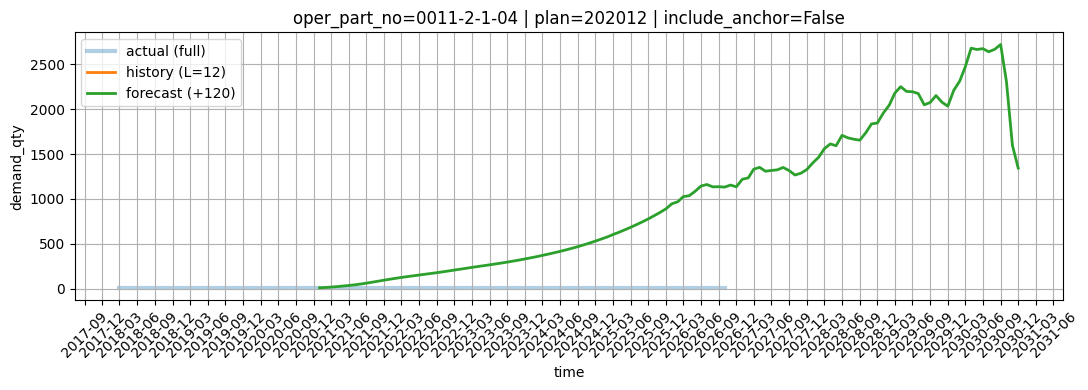

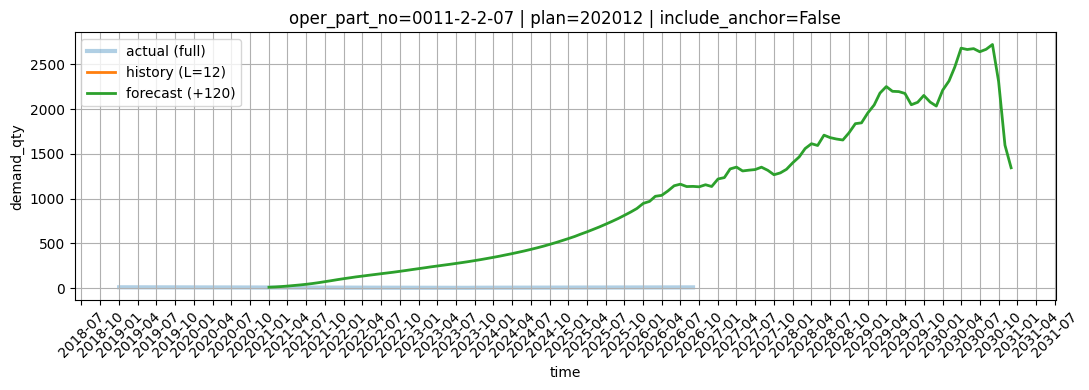

In [6]:
from utils.plot_utils import plot_anchored_forecasts_yyyymm

plot_anchored_forecasts_yyyymm(
    df=target_dyn_demand,
    parts=parts_batch,
    y_hat=y_hat_120,
    plan_yyyymm=plan_yyyymm,
    lookback=data_module.config.lookback,
    part_col="oper_part_no",
    date_col="demand_dt",
    qty_col="demand_qty",
    k=6,
    include_anchor=False,     # plan 다음 달부터 120개월
    outdir="./plots",
    prefix="anchored_hybrid_120"
)